# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# for loading sqllite data 
from sqlalchemy import create_engine
#for Export  model as a pickle file
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download(['punkt', 'wordnet'])
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
pd.read_sql_table?

In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterDatabase.db')
df = pd.read_sql_table("DisaterResponse", con=engine)
X = df['message']
Y = df.drop(['id','message','original','genre'], axis = 1)
category_names = df.columns[4:]
category_names

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

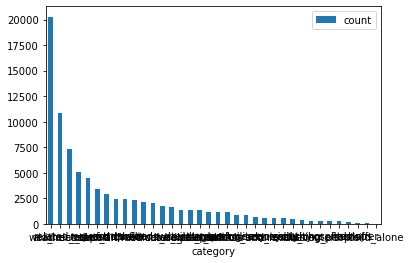

In [17]:
#df.groupby('genre').count()
category_labels=df.iloc[:,4:].sum().sort_values(ascending=False).reset_index()
category_labels.columns=['category','count']
category_labels.plot.bar(x='category', y='count', rot=0)



### 2. Write a tokenization function to process your text data

In [37]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        # lemmatize, normalize case, and remove leading/trailing white space
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens
    pass

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [38]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf',MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [39]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y)

#train pipeline
pipeline.fit(X_train.values, y_train.values)

y_pred = pipeline.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [43]:

def get_results(y_test, y_pred):
    
    num = 0
    result1 = []
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        result1.append([cat, float(f_score), float(precision), float(recall)])
        num += 1
        
    results = pd.DataFrame(result1, columns=['Category', 'f_score', 'precision', 'recall'])
    print('Average f_score:', results['f_score'].mean())
    print('Average precision:', results['precision'].mean())
    print('Average recall:', results['recall'].mean())
    return results

In [44]:
model_results = get_results(y_test, y_pred)
model_results.head()

Aggregated f_score: 0.9321247423905271
Aggregated precision: 0.9390494364173908
Aggregated recall: 0.9462584342047268


E:\SoftwareInstallation\ancnda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,f_score,precision,recall
0,related,0.767602,0.793814,0.805157
1,request,0.883896,0.896985,0.897925
2,offer,0.992454,0.989955,0.994965
3,aid_related,0.760609,0.768343,0.766250
4,medical_help,0.884783,0.895627,0.918370


### 6. Improve your model
Use grid search to find better parameters. 

In [45]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001DDEFF2A280>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001DDEFF2A280>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,


In [46]:
parameters = {'clf__estimator__n_estimators': [20,50,70],
             'clf__estimator__min_samples_split': [2, 3]}


# 'clf__n_estimators': [50, 100, 200],
# 'clf__min_samples_split': [2, 3, 4],
# 'clf__estimator__max_depth': [10, 50, None],
# 'clf__estimator__min_samples_leaf':[2, 10]
# 'clf__estimator__n_estimators': [20,50,70],
# 'clf__estimator__learning_rate': [0.1,0.2,0.5]

            

cv = GridSearchCV(pipeline, parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [47]:
cv.fit(X_train.values, y_train.values)
y_pred = cv.predict(X_test)
results_cv = get_results(y_test, y_pred)
results_cv

E:\SoftwareInstallation\ancnda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregated f_score: 0.9317342107896126
Aggregated precision: 0.9376673203039277
Aggregated recall: 0.9458897026413047


,Category,f_score,precision,recall
0,related,0.764861,0.792115,0.803479
1,request,0.879368,0.894326,0.894873
2,offer,0.992454,0.989955,0.994965
3,aid_related,0.762248,0.771101,0.768233
4,medical_help,0.884518,0.891967,0.917913
5,medical_products,0.939240,0.952064,0.956973
6,search_and_rescue,0.957787,0.962259,0.970857
7,security,0.974818,0.983351,0.983064
8,military,0.950093,0.954467,0.965212
9,child_alone,1.000000,1.000000,1.000000


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [49]:
# adding StartingVerbExtractor features besides the TF-IDF
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [51]:
# comparing different model performance
    
ml_algo=[RandomForestClassifier(),DecisionTreeClassifier(),AdaBoostClassifier()]

df_temp = []
for algorithm in ml_algo:
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            ('starting_verb', StartingVerbExtractor())
        ])),
        ('clf', MultiOutputClassifier(algorithm))
    ])
    
    models_type=str(type(algorithm)).split('.')[-1][:-2]
    pipeline.fit(X_train.values, y_train.values)
    y_pred = pipeline.predict(X_test)
    results = get_results(y_test, y_pred)
    
    df_temp.append([models_type, results['f_score'].mean(), results['precision'].mean(), results['recall'].mean()])
    
df = pd.DataFrame(df_temp, columns = ['Model',  'f_score', 'precision', 'recall'])
df

E:\SoftwareInstallation\ancnda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregated f_score: 0.9323657981923549
Aggregated precision: 0.9372458977523735
Aggregated recall: 0.9463898213135321
Aggregated f_score: 0.9300666016343162
Aggregated precision: 0.9291498893853574
Aggregated recall: 0.9310811039907774
Aggregated f_score: 0.941104529354003
Aggregated precision: 0.9404681609222598
Aggregated recall: 0.947979181500695


,Model,f_score,precision,recall
0,RandomForestClassifier,0.932366,0.937246,0.946390
1,DecisionTreeClassifier,0.930067,0.929150,0.931081
2,AdaBoostClassifier,0.941105,0.940468,0.947979


We found that AdaBoostClassifier() has better accuracy score compared to other algorithms. Hence, in the next step fine tune the model parameters and run the model.

In [50]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            
            ('starting_verb', StartingVerbExtractor())
        ])),
        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
    ])


parameters= {
        'clf__estimator__n_estimators': [10,40,60],
        'clf__estimator__learning_rate': [0.2,0.3,0.5]
}


cv_ada = GridSearchCV(pipeline, parameters)

cv_ada.fit(X_train.values, y_train.values)
y_pred = cv_ada.predict(X_test)
ada_results = get_results(y_test, y_pred)
ada_results

Aggregated f_score: 0.9375688357683301
Aggregated precision: 0.9396799189413438
Aggregated recall: 0.9478986539178789


E:\SoftwareInstallation\ancnda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,f_score,precision,recall
0,related,0.709587,0.723811,0.768691
1,request,0.892002,0.897581,0.901892
2,offer,0.992148,0.989952,0.994355
3,aid_related,0.735096,0.747715,0.743821
4,medical_help,0.901078,0.905366,0.922948
5,medical_products,0.953896,0.955331,0.962161
6,search_and_rescue,0.962209,0.969965,0.972841
7,security,0.975473,0.979371,0.983216
8,military,0.963584,0.966071,0.970857
9,child_alone,1.000000,1.000000,1.000000


### 9. Export your model as a pickle file

In [52]:
file_name = 'ada_model.pkl'
with open (file_name, 'wb') as f:
    pickle.dump(cv_ada, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.